# Simplifying Science: Utilizing BERT and SciBERT for Scientific and Plain Language Text Classification
***Can an NLP model aid in identifying scientific jargon by classifying text as scientific or plain language?***
<br>
This notebook compares the performance of BERT and [SciBERT](https://huggingface.co/allenai/scibert_scivocab_uncased) (a BERT variant pre-trained on scientific corpora) when tasked with distinguishing between scientific jargon and plain language texts using the PLABA dataset. 
<br>
Emily Robles, DATASCI 266 Fall 2023


## SETUP

In [1]:
# !pip install tensorflow-datasets --quiet
# !pip install -U tensorflow-text --quiet
# !pip install transformers --quiet
# !pip install torch torchvision

In [2]:
import json
import pandas as pd

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
from sklearn.metrics import f1_score, recall_score
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import string
import torch



## Create DataFrame

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
val = pd.read_csv("data/val.csv")

In [6]:
full_input = {}
full_target = {}
# 1 for scientific, 0 for jargon

for i in train.input_text:
  full_input[i] = 1

for i in test.input_text:
  full_input[i] = 1

for i in val.input_text:
  full_input[i] = 1

for t in train.target_text:
  full_target[t] = 0

for t in test.target_text:
  full_target[t] = 0

for t in val.target_text:
  full_target[t] = 0

In [7]:
df_scientific = pd.DataFrame(list(full_input.items()), columns=['text', 'label'])
df_plain_language = pd.DataFrame(list(full_target.items()), columns=['text', 'label'])

df_combined = pd.concat([df_scientific, df_plain_language])

df_combined.reset_index(drop=True, inplace=True)

In [8]:
data = df_combined.sample(frac=1, random_state=41).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
#data.head(3)

In [ ]:
#data.to_csv('/content/drive/My Drive/full_dataset_labeled.csv', index=False)

In [9]:
len(data)

1671

## PREPROCESSING

In [ ]:
# NLTK setup

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [ ]:
EMBEDDING_DIM = len(model['delay'])      # is known 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape


(43982, 300)

## Setup Data for Baseline and BERT Models

In [10]:
# lowercasing
data['text'] = data['text'].apply(lambda x: x.lower())

# remove punctuation
data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [11]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# could break here and do eda on train

train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['label'].values))
test_data = tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['label'].values))

# don't need to batch, the dataset size is small enough
train_examples, train_labels = next(iter(train_data.batch(len(train_df) + 1)))
test_examples, test_labels = next(iter(test_data.batch(len(test_df) + 1)))



In [28]:
test_examples[:2]

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'pressure injury pi is used to describe skin damage not caused by underlying diseases pi affects strength of the skin pi is produced by prolonged pressure or friction between a hard internal and external surface treatment can be challenging when there is no solution with usual clinical care the use of autologous plateletrich plasma aprp gel is a possible therapeutic medical option for chronic pressure injuries aprp uses injections of the patients own platelets blood cells to increase healing rates the case of a patient with chronic pi who has been treated with aprp is presented achieving resolution healing of the lesion wound',
       b'objective postpartum mood disorders represent a serious problem affecting 1020 of women and support groups offer a promising intervention modality the current study examined participant satisfaction with and effectiveness of a peerfacilitated postpartum support group intervention the program consists 

In [ ]:
train_df

,text,label
266,human chorionic gonadotropin hcg is a pregnancy hormone the hormone is secreted by the outermost layer of the placenta the hormone has been linked to fetal growth and various placental uterine and fetal functions to investigate the effects of hcg on clinical endpoints having knowledge on reference range rr methodology and determinants of gestational hcg levels is crucial also a better understanding of gestational hcg function can improve current screening programs and future clinical management serum blood hcg levels were determined in 8195 women gestational age specific rrs using ultrasound derived gestational age us rrs were calculated this data was compared with last menstrual period derived gestational age lmp rrs and a modelbased rr the study also investigated which pregnancy characteristics were associated with hcg levels compared to the us rrs the lmp rrs were lower no considerable differences were found between rrs calculated in the general population or in uncomplicated pregnancies only maternal smoking bmi monetary income ethnicity fetal gender placental weight and vomiting associated with pregnancy were correlated with total hcg this study provides gestational rrs for total hcg additionally this study shows total hcg values and rr cutoffs during pregnancy vary depending on pregnancy dating methodology this is likely due to the influence of hcg on embryonic growth this suggests that ultrasound based pregnancy dating might be less reliable in women with highlow hcg levels furthermore this study identifies different pregnancy characteristics that influence total hcg levels these pregnancy characteristics should therefore be accounted for in clinical studies,0
148,side effects of the brain and spine are commonly reported with pregabalin pgb a common nerve pain medication however movement disorders mds linked with this drug were rarely described still their occurence could affect the quality of life of pgb users this review evaluates the distribution diseasecausing mechanisms and treatment of pgbassociated mds two reviewers without language issues identified and checked relevant reports in six databases 46 reports with 305 cases from 17 countries were assessed the reported mds include 184 people with ataxia impaired coordination 61 with tremors shaking movements 39 with myoclonus muscle jerks 8 with parkinsonism movement abnormalities from a brain disorder 1 with restless legs syndrome uncontrollable urge to move legs 1 with dystonia repetitive twisting movements 1 with dyskinesia erratic movements and 1 with akathisia muscle quivering average age was 62 years proportion of male sex was 5434 average pgb medication dose when md occured was 238 mg nerverelated pain was the most common effect of pgb time from pgb start to md was 1 month at 75 time from pgd drug use withdrawal to recovery was 1 week at 77 all individuals with a reported followup or later examination had a full recovery most common management was pgb drug withdrawal in the text many cases did not report information about timeline events brainrelated exam details or details about the electrical activity of the body the best treatment for all mds is likely pgb drug use stoppage if the patient is on an artificial kidney machine perhaps more sessions will decrease recovery time also adding a benzodiazepine an antianxiety and antiseizure drug could quicken recovery,0
381,certain molecular tools called rtpcr assays test for infection with the sarscov2 virus which can cause a threatening breathingrelated illness rtpcr tests are very specific and detecting a target when there is none or a false positive is low however not detecting a target when there is one or a false negative is possible depending on the swab and time since symptoms the authors aim is to determine the likelihood of a falsenegative test in infected patients is affected by time since symptoms and swab type the chance of detecting the target decreased with time since symptoms also orop

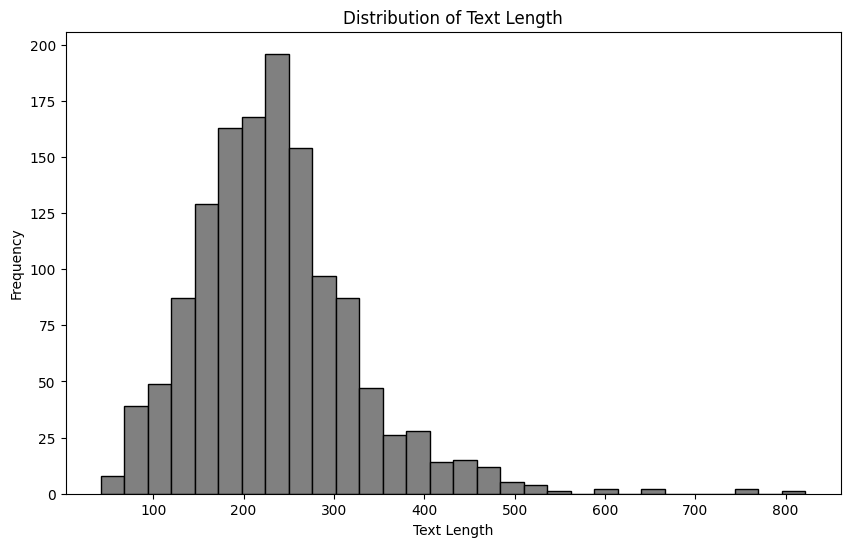

In [97]:
# let's look at lengths of text to see what we should choose as our max
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, color='gray', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

In [23]:
MAX_SEQUENCE_LENGTH = 250


# Data Preparation for Baseline

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

In [ ]:
# look at tokens
train_tokens[1335]

<tf.Tensor: shape=(196,), dtype=string, numpy=
array([b'in', b'patients', b'with', b'advancedstage', b'chronic',
       b'kidney', b'disease', b'ckd', b'progressive', b'kidney',
       b'function', b'decline', b'leads', b'to', b'increased', b'risk',
       b'for', b'hyperkalemia', b'serum', b'potassium', b'50', b'or',
       b'55', b'meql', b'medications', b'such', b'as',
       b'reninangiotensinaldosterone', b'system', b'inhibitors', b'pose',
       b'an', b'additional', b'hyperkalemia', b'risk', b'especially',
       b'in', b'patients', b'with', b'ckd', b'when', b'hyperkalemia',
       b'develops', b'clinicians', b'often', b'recommend', b'a', b'diet',
       b'that', b'is', b'lower', b'in', b'potassium', b'content', b'this',
       b'review', b'discusses', b'the', b'barriers', b'to', b'adherence',
       b'to', b'a', b'lowpotassium', b'diet', b'and', b'the', b'impact',
       b'of', b'dietary', b'restrictions', b'on', b'adverse', b'clinical',
       b'outcomes', b'accumulating', b'e

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return np.array(texts_vocab_ids)

In [ ]:
train_input_ids = docs_to_vocab_ids(train_tokens)
test_input_ids = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels)
test_input_labels = np.array(test_labels)

Examples processed:  0
Total examples:  1335
Examples processed:  0
Total examples:  334


In [ ]:
train_input_labels[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

# BASELINE: Simple Neural Network

To set a baseline for the rest of our work, we start with a simple Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

nn_input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

nn_embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                               output_dim=EMBEDDING_DIM,
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)(nn_input_layer)

nn_global_avg_pooling = GlobalAveragePooling1D()(nn_embedding_layer)

nn_dropout = Dropout(0.5)(nn_global_avg_pooling)  # 50% dropout rate

nn_classification = Dense(1, activation='sigmoid', name='classification')(nn_dropout)

nn_model = Model(inputs=nn_input_layer, outputs=[nn_classification])

nn_model.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

# Model summary for a quick overview
nn_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          13194600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 classification (Dense)      (None, 1)                 301       
                                                                 
Total params: 13194901 (50.33 MB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 13194600 (50.33 MB)
___________________

Epoch 1/10
42/42 [==============================] - 2s 26ms/step - loss: 0.6910 - accuracy: 0.5464 - val_loss: 0.6898 - val_accuracy: 0.5313
Epoch 2/10
42/42 [==============================] - 1s 25ms/step - loss: 0.6865 - accuracy: 0.5561 - val_loss: 0.6873 - val_accuracy: 0.5313
Epoch 3/10
42/42 [==============================] - 1s 19ms/step - loss: 0.6837 - accuracy: 0.5561 - val_loss: 0.6855 - val_accuracy: 0.5313
Epoch 4/10
42/42 [==============================] - 1s 18ms/step - loss: 0.6811 - accuracy: 0.5561 - val_loss: 0.6841 - val_accuracy: 0.5313
Epoch 5/10
42/42 [==============================] - 1s 15ms/step - loss: 0.6787 - accuracy: 0.5561 - val_loss: 0.6829 - val_accuracy: 0.5313
Epoch 6/10
42/42 [==============================] - 1s 14ms/step - loss: 0.6773 - accuracy: 0.5561 - val_loss: 0.6820 - val_accuracy: 0.5313
Epoch 7/10
42/42 [==============================] - 1s 15ms/step - loss: 0.6756 - accuracy: 0.5561 - val_loss: 0.6810 - val_accuracy: 0.5313
Epoch 8/10
42

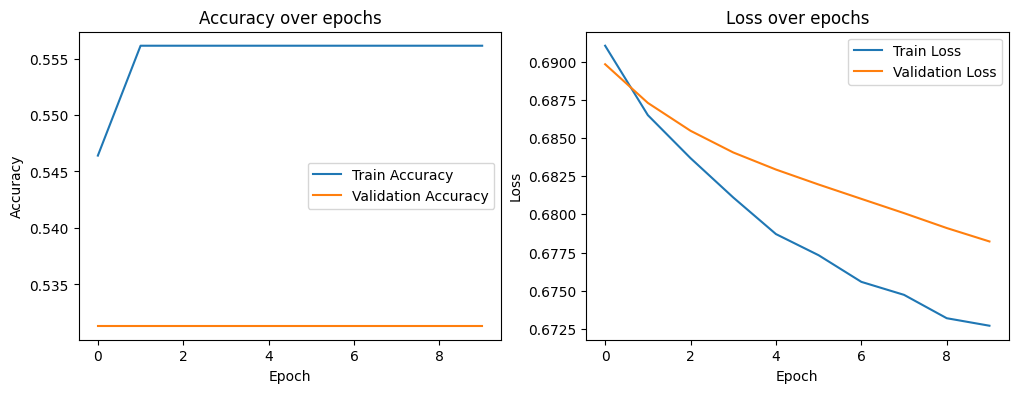

In [ ]:
# train baseline
history = nn_model.fit(train_input_ids, train_input_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_input_ids, test_input_labels),
                    verbose=1)

# evaluate the baseline on the test set
test_loss, test_accuracy = nn_model.evaluate(test_input_ids, test_input_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# plot the history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


As expected, the baseline does not perform particularly well. On to BERT!

# MODEL ONE: BERT

## Training/Test Sets for BERT-based models

In [13]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [25]:
# data preparation and tokenization
train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

# Preparing Inputs and Labels
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

In [26]:
max_token_id = max([max(seq) for seq in bert_train_tokenized.input_ids.numpy()])
print("Maximum token ID:", max_token_id)
print("BERT vocabulary size:", bert_model.config.vocab_size)


Maximum token ID: 30141
BERT vocabulary size: 30522


In [27]:
bert_train_inputs

[<tf.Tensor: shape=(1336, 250), dtype=int32, numpy=
 array([[  101,  2529, 16480, ...,  1998, 25269,   102],
        [  101,  2217,  3896, ...,  2001, 18720,   102],
        [  101,  3056,  8382, ...,  3893,  2051,   102],
        ...,
        [  101,  2566,  8458, ...,     0,     0,     0],
        [  101,  1996,  2120, ...,     0,     0,     0],
        [  101,  1999,  5022, ...,  2152, 11008,   102]], dtype=int32)>,
 <tf.Tensor: shape=(1336, 250), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(1336, 250), dtype=int32, numpy=
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>]

In [31]:
bert_train_labels.shape

(1336,)

In [28]:
# BERT UNCASED

input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
token_type_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')
attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')


bert_outputs = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)

pooled_output = bert_outputs[1]

output = Dense(1, activation='sigmoid')(pooled_output)

model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[output])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 250)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                            

In [29]:
model.fit([bert_train_inputs[0],  # input_ids
           bert_train_inputs[1],  # token_type_ids
           bert_train_inputs[2]], # attention_mask
          bert_train_labels,
          batch_size=6,
          epochs=3,
          validation_data=([bert_test_inputs[0],  # input_ids
                            bert_test_inputs[1],  # token_type_ids
                            bert_test_inputs[2]], # attention_mask
                           bert_test_labels))

Epoch 1/3
223/223 [==============================] - 1049s 5s/step - loss: 0.4153 - accuracy: 0.7912 - val_loss: 0.1791 - val_accuracy: 0.9284
Epoch 2/3
223/223 [==============================] - 1022s 5s/step - loss: 0.1450 - accuracy: 0.9431 - val_loss: 0.1063 - val_accuracy: 0.9612
Epoch 3/3
223/223 [==============================] - 1029s 5s/step - loss: 0.0861 - accuracy: 0.9678 - val_loss: 0.0911 - val_accuracy: 0.9701


### BERT base evaluation

In [74]:
# evaluate the base4 BERT model on the test set
test_loss, test_accuracy = model.evaluate([bert_test_inputs[0],  # input_ids
                                           bert_test_inputs[1],  # token_type_ids
                                           bert_test_inputs[2]], # attention_mask
                                          bert_test_labels,
                                          batch_size=6)

# predictions
bert_predictions = model.predict([bert_test_inputs[0], bert_test_inputs[1], bert_test_inputs[2]])
bert_predictions = np.round(bert_predictions).astype(int)  # Convert predictions to binary labels

# F1 Score and Recall
bert_f1 = f1_score(bert_test_labels, bert_predictions)
bert_recall = recall_score(bert_test_labels, bert_predictions)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100}%")
print(f"BERT Model F1 Score: {bert_f1}")
print(f"BERT Model Recall: {bert_recall}")

11/11 [==============================] - 81s 7s/step
Test Loss: 0.09113013744354248
Test Accuracy: 97.0149278640747%
BERT Model F1 Score: 0.9683544303797469
BERT Model Recall: 0.9745222929936306


In [77]:
test_texts = list(test_df.text)

In [82]:
# test labels to a flat array for easy comparison
bert_predictions_binary = np.round(bert_predictions).astype(int).flatten()  # Convert to binary labels
bert_test_labels_flat = bert_test_labels.flatten()

# identify indices of false positives and false negatives
false_positives = np.where((bert_predictions_binary == 1) & (bert_test_labels_flat == 0))[0]
false_negatives = np.where((bert_predictions_binary == 0) & (bert_test_labels_flat == 1))[0]

In [87]:
len(false_positives), len(false_negatives)

(6, 4)

In [96]:
# DataFrame for False Positives
false_positives_df = pd.DataFrame({
    'Text': [test_texts[idx] for idx in false_positives],  # Adjust the number as needed
    'Predicted Label': [bert_predictions[idx] for idx in false_positives],
    'True Label': [bert_test_labels[idx] for idx in false_positives]
})
false_positives_df['Predicted Label'] = false_positives_df['Predicted Label'].apply(lambda x: x[0])

# Create DataFrame for False Negatives
false_negatives_df = pd.DataFrame({
    'Text': [test_texts[idx] for idx in false_negatives],
    'Predicted Label': [bert_predictions[idx] for idx in false_negatives],
    'True Label': [bert_test_labels[idx] for idx in false_negatives]
})
false_negatives_df['Predicted Label'] = false_negatives_df['Predicted Label'].apply(lambda x: x[0])

# Display the DataFrames
print("False Positive Examples:")
display(false_positives_df)

print("\nFalse Negative Examples:")
display(false_negatives_df)



False Positive Examples:


,Text,Predicted Label,True Label
0,polyuriapolydipsia syndrome consists of the three main effects central or nephrogenic kidneyrelated diabetes insipidus constantlyurinating and primary polydipsia great thirst reliable differences between these diagnoses is needed as treatment differs greatly with the wrong treatment potentially leading to serious side effects past identification measures using the classical water deprivation test had several pitfalls and clinicians were often left with uncertainity regarding the diagnosis with the creation of copeptin a stable and reliable surrogate marker for arginine vasopressin blood vessel constriction diagnosis of the polyuriapolydipsia syndrome has been newly evaluated whereas unstimulated basal copeptin specific protein measurement reliably identifies nephrogenic diabetes insipidus two new tests using stimulated copeptin cutoffs showed a high identification accuracy in differentiating central diabetes insipidus from primary polydipsia for the hypertonic very salty saline infusion test watersucking stimulation via a high salt amount is used this makes the test highly reliable and superior to the classical water deprivation test but also requires close watch and the availability of rapid sodium measurements to guarantee the tests safety alternatively arginine infusion adding a specific protein in can be used to stimulate copeptin release opening the doors for an even shorter and safer diagnostic test the test protocols of the two tests are provided and a new copeptinbased diagnostic method is proposed to reliably identify between the different entities furthermore the role of copeptin as a predictive marker for the development of diabetes insipidus following surgeries in the sellar region an area of the head is described,1,0
1,this study is a literature review of chronic fatigue syndrome cfs longlasting tiredness this study provides a description of the background cause development diagnosis and management regarding cfs cfs is a multifaceted illness that has many symptoms and a wide array of clinical presentations as of recent cfs has been merged with myalgic encephalomyelitis me me is a disease characterized with profound fatigue abnormal sleep and pain much of the difficulty in its management has stemmed from a lack of a concrete understanding of its cause and development there is a potential association between dysfunction of the autoimmune immune cells attacking healthy cells neuroendocrine brain and hormonalrelated system or autonomic nervous systems and cfs development possible triggering events such as infections followed by an immune dysregulation have been proposed as potential causes mecfs was first described following epstein barr virus ebv herpes virus infections it was later determined that it was not always preceded by ebv infection patient diagnosed with cfs have shown a noticeably earlier activation of anaerobic metabolism nooxygen energy production on the cellular level as a source of energy this suggests impaired oxygen consumption the differential different diagnoses range from tickborne illnesses to psychiatric disorders to metabolismregulating thyroid gland dysfunction the many overlapping symptoms of cfs with other illnesses makes diagnosis very hard the centers for disease control and prevention cdc considers it a diagnosing of exclusion meaning other illnesses have to first be excluded before cfs diagnosis can be offered the cdc states that selfreported fatigue for a minimum of six months and four additional symptoms are necessary for diagnosis these symptoms include memory problems sore throat postexertion illness tender cervical neck or axillary armpit lymph nodes muscle pain multijoint pain headaches and troubled sleep management of cfs is just as difficult treatment ranges from conservative eg antidepressants to minimally invasive surgical management minimally invasive management can involve transcutaneous electrical acupoint stimulation nonsurgical electrical


False Negative Examples:


,Text,Predicted Label,True Label
0,there have been reports of myocarditis following covid19 vaccination we surveyed all hospitalized military personnel in the isareli defense forces during the period of the covid19 vaccination operation 12282021372021 for diagnosed myocarditis we identified 7 cases of myocarditis with symptoms starting in the first week after the second dose of covid19 pfizerbiontech vaccine one case of myocarditis diagnosed 10 days after the second dose of the vaccine was not included these 8 cases comprise of all events of myocarditis diagnosed in military personnel during this time period all patients were young and generally healthy all had mild disease with no sequalae the incidence of myocarditis in the week following a second dose of the vaccine was 507100000 people vaccinated due to the nature of this report no causality could be established clinicians should be aware of the possibility of myocarditis following pfizerbiontech vaccination true incidence rates should be further investigated,0,1
1,cardiac implantable electronic devices cieds provide lifesaving therapy for the treatment of bradyarrhythmias ventricular tachyarrhythmias and advanced systolic heart failure all pacemakers have 2 basic functions 1 to pace and 2 to sense intrinsic electrical activity of the heart most pacemakers are programmed to inhibit pacing when they sense native electrical activity and only pace in the absence of intrinsic electrical activity more specifically pacemakers can be programmed to set which chamber or chambers will pace which chamber or chambers will sense intrinsic electrical activity how the pacemaker will respond to sensed electrical activity ie inhibit pacing and if rateadaptive pacing will be used,0,1
2,47xxx triple x and turner syndrome 45x are sex chromosomal abnormalities with detrimental effects on health with increased mortality and morbidity in karyotypical normal females xchromosome inactivation balances gene expression between sexes and upregulation of the x chromosome in both sexes maintain stoichiometry with the autosomes in 47xxx and turner syndrome a gene dosage imbalance may ensue from increased or decreased expression from the genes that escape x inactivation as well as from incomplete x chromosome inactivation in 47xxx we aim to study genomewide dnamethylation and rnaexpression changes can explain phenotypic traits in 47xxx syndrome we compare dnamethylation and rnaexpression data derived from white blood cells of seven women with 47xxx syndrome with data from seven female controls as well as with seven women with turner syndrome 45x to address these questions we explored genomewide dnamethylation and transcriptome data in blood from seven females with 47xxx syndrome seven females with turner syndrome and seven karyotypically normal females 46xx based on promoter methylation we describe a demethylation of six xchromosomal genes amot htr2c il1rapl2 stag2 tceanc znf673 increased methylation for gemin8 and four differentially methylated autosomal regions related to four genes speg muc4 sp6 and znf492 we illustrate how these changes seem compensated at the transcriptome level although several genes show differential exon usage in conclusion our results suggest an impact of the supernumerary x chromosome in 47xxx syndrome on the methylation status of selected genes despite an overall comparable expression profile,0,1
3,several risk factors for asthma have been linked with exposures during pregnancy making their true effects similarly hard to elucidate given the constraints of conducting research in this particular group and the difficulty of interpreting any findings a report published in pediatrics outlined the effects of maternal and infant nutrition on the development of atopic disease including asthma in children reflecting that multiple factors could act in concert to influence disease development maternal exposure to vitamin d has been investigated as a risk factor for childhood asthma and wh

# MODEL TWO: SCIBERT

In [47]:
from transformers import AutoTokenizer, TFAutoModel

scibert_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
scibert_model = TFAutoModel.from_pretrained('allenai/scibert_scivocab_uncased', from_pt=True)


In [40]:
scibert_train_tokenized = scibert_tokenizer(train_examples_str,
                                            max_length=MAX_SEQUENCE_LENGTH,
                                            truncation=True,
                                            padding='max_length',
                                            return_tensors='tf')

scibert_train_inputs = [scibert_train_tokenized.input_ids,
                        scibert_train_tokenized.token_type_ids,
                        scibert_train_tokenized.attention_mask]

scibert_test_tokenized = scibert_tokenizer(test_examples_str,
                                           max_length=MAX_SEQUENCE_LENGTH,
                                           truncation=True,
                                           padding='max_length',
                                           return_tensors='tf')

scibert_test_inputs = [scibert_test_tokenized.input_ids,
                       scibert_test_tokenized.token_type_ids,
                       scibert_test_tokenized.attention_mask]


In [48]:
input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
token_type_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')
attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

scibert_outputs = scibert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
pooled_output = scibert_outputs[1]

output = Dense(1, activation='sigmoid')(pooled_output)

scibert_model_final = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[output])

scibert_model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])


In [49]:
scibert_model_final.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 250)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                            

Epoch 1/3
223/223 [==============================] - 1064s 5s/step - loss: 0.2905 - accuracy: 0.8668 - val_loss: 0.1360 - val_accuracy: 0.9493
Epoch 2/3
223/223 [==============================] - 1014s 5s/step - loss: 0.0832 - accuracy: 0.9701 - val_loss: 0.0946 - val_accuracy: 0.9642
Epoch 3/3
223/223 [==============================] - 1009s 5s/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.1268 - val_accuracy: 0.9463


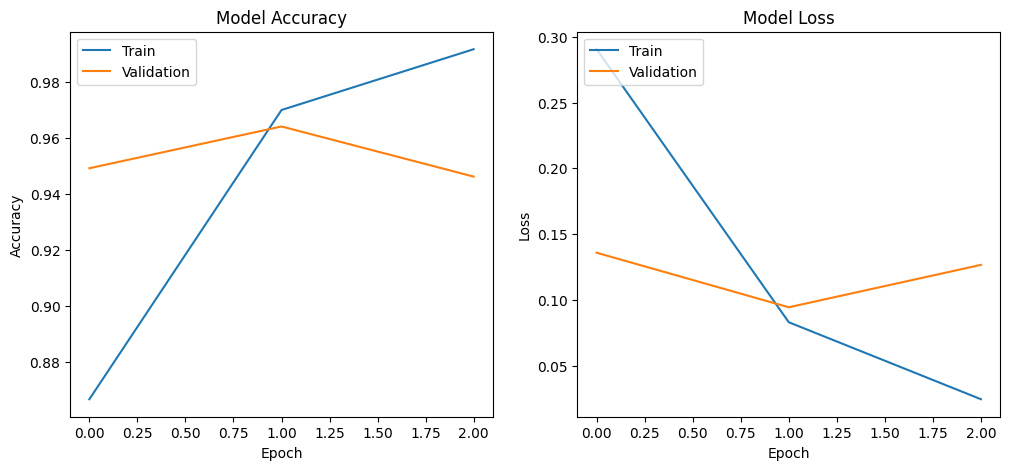

In [50]:
scibert_model_final.fit([scibert_train_inputs[0], scibert_train_inputs[1], scibert_train_inputs[2]],
                                  bert_train_labels,
                                  batch_size=6,
                                  epochs=3,
                                  validation_data=([scibert_test_inputs[0], scibert_test_inputs[1], scibert_test_inputs[2]],
                                                   bert_test_labels))


The validation loss decreases initially but then increases slightly in the third epoch. I'd like to train for more epochs, but want to avoid overfitting, so let's add in a dropout layer.

In [62]:
input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
token_type_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')
attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

scibert_outputs = scibert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
pooled_output = scibert_outputs[1]

# add a dropout layer
dropout = Dropout(0.5)(pooled_output)  # 50% dropout

output = Dense(1, activation='sigmoid')(dropout)


scibert_model_updated = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[output])

scibert_model_updated.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])
scibert_model_updated.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 250)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                            

In [63]:
# Train the updated SciBERT model
scibert_model_updated.fit([scibert_train_inputs[0], scibert_train_inputs[1], scibert_train_inputs[2]],
                                  bert_train_labels,
                                  batch_size=6,
                                  epochs=5,
                                  validation_data=([scibert_test_inputs[0], scibert_test_inputs[1], scibert_test_inputs[2]],
                                                   bert_test_labels))


Epoch 1/5
223/223 [==============================] - 1031s 5s/step - loss: 0.3921 - accuracy: 0.8204 - val_loss: 0.1751 - val_accuracy: 0.9313
Epoch 2/5
223/223 [==============================] - 1007s 5s/step - loss: 0.1320 - accuracy: 0.9543 - val_loss: 0.0575 - val_accuracy: 0.9821
Epoch 3/5
223/223 [==============================] - 1032s 5s/step - loss: 0.0848 - accuracy: 0.9686 - val_loss: 0.1166 - val_accuracy: 0.9493
Epoch 4/5
223/223 [==============================] - 1024s 5s/step - loss: 0.0302 - accuracy: 0.9925 - val_loss: 0.1229 - val_accuracy: 0.9642
Epoch 5/5
223/223 [==============================] - 1051s 5s/step - loss: 0.0188 - accuracy: 0.9963 - val_loss: 0.0696 - val_accuracy: 0.9791


In [68]:
# Evaluate the BERT model on the test set
test_loss, test_accuracy = scibert_model_updated.evaluate([scibert_test_inputs[0],  # input_ids
                                           scibert_test_inputs[1],  # token_type_ids
                                           scibert_test_inputs[2]], # attention_mask
                                          bert_test_labels,
                                          batch_size=6)


scibert_predictions = scibert_model_updated.predict([scibert_test_inputs[0], scibert_test_inputs[1], scibert_test_inputs[2]])
scibert_predictions = np.round(scibert_predictions).astype(int)  # Convert predictions to binary labels

scibert_f1 = f1_score(bert_test_labels, scibert_predictions)
scibert_recall = recall_score(bert_test_labels, scibert_predictions)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100}%")
print(f"SciBERT Model F1 Score: {scibert_f1}")
print(f"SciBERT Model Recall: {scibert_recall}")

11/11 [==============================] - 79s 7s/step
Test Loss: 0.06958159059286118
Test Accuracy: 97.91044592857361%
SciBERT Model F1 Score: 0.9779179810725551
SciBERT Model Recall: 0.9872611464968153


In [90]:
scibert_predictions_binary = np.round(scibert_predictions).astype(int).flatten()  # Convert to binary labels
scibert_test_labels_flat = bert_test_labels.flatten()

sci_false_positives = np.where((scibert_predictions_binary == 1) & (scibert_test_labels_flat == 0))[0]
sci_false_negatives = np.where((scibert_predictions_binary == 0) & (scibert_test_labels_flat == 1))[0]


In [91]:
len(sci_false_positives), len(sci_false_negatives)

(5, 2)

In [95]:
sci_false_positives_df = pd.DataFrame({
    'Text': [test_texts[idx] for idx in sci_false_positives],
    'Predicted Label': [scibert_predictions[idx] for idx in sci_false_positives],
    'True Label': [bert_test_labels[idx] for idx in sci_false_positives]
})
sci_false_positives_df['Predicted Label'] = sci_false_positives_df['Predicted Label'].apply(lambda x: x[0])

sci_false_negatives_df = pd.DataFrame({
    'Text': [test_texts[idx] for idx in sci_false_negatives],
    'Predicted Label': [scibert_predictions[idx] for idx in sci_false_negatives],
    'True Label': [bert_test_labels[idx] for idx in sci_false_negatives]
})
sci_false_negatives_df['Predicted Label'] = sci_false_negatives_df['Predicted Label'].apply(lambda x: x[0])

print("SciBERT False Positive Examples:")
display(sci_false_positives_df)

print("\nSciBERT False Negative Examples:")
display(sci_false_negatives_df)

SciBERT False Positive Examples:


,Text,Predicted Label,True Label
0,fibroblast growth factor receptor 3 fgfr3 gainoffunction mutations cause dwarfisms including achondroplasia ach and thanatophoric dysplasia td the continuously active state of fgfr3 disrupts normal process of bone growth bonegrowth abnormalities have been identified in which primary cilia pc function is disrupted primary cilia are long protrusions on cells that act as an antenna and are important during development in human ach and td the impact of fgfr3 mutations on pc in growth plate cartilage remains unknown here the authors showed that in cartilage cells from ach and td patients and mice with fgfr3 mutation the fgfr3 is overactive and it perturbed pc length and formation they demonstrated that inhibiting fgfr3 using a drug inhibitor rescued both pc length and formation the authors also studied the impact of a drug inhibitor of a signaling pathway interestingly the drug also rescued pc length and formation together we provide evidence that the growth plate defects ascribed to fgfr3related dwarfisms are potentially due to loss of pc function and these dwarfisms may represent a novel type of bone growth disorders with defective cilia formation,1,0
1,mutations in fibroblast growth factor receptor 3 fgfr3 cause achondroplasia ach the most common form of dwarfism in humans and related chondrodysplasia syndromes that include hypochondroplasia hch severe achondroplasia with developmental delay and acanthosis nigricans saddan and thanatophoric dysplasia td the mutations are passed on nonsex chromosomes and causes the child that inherits the mutation from an affected parent to have a 50 chance to be affected fgfr3 is expressed in cartilage cells and mature boneforming cells where it functions to regulate bone growth analysis of the mutations in fgfr3 revealed increased signaling through a combination of mechanisms that include stabilization of the receptor enhanced binding of two receptors to each other and enhanced enzyme activity of the receptor paradoxically increased fgfr3 signaling profoundly suppresses cell multiplication and maturation of growth plate cartilage cells resulting in decreased growth region size reduced volume of the ends of long bones and resulting decreased bone elongation in this review authors discuss the molecular mechanisms that regulate growth region cartilage cells development of achondroplasia ach and therapeutic approaches that are being evaluated to improve bone growth in people with ach and related conditions,1,0
2,this study compares the effects and abrupt stoppage of anxietyreducing buspirone drug use 15 or 20 mg three times a day and anxietyreducing lorazepam drug use 3 or 4 mg three times a day after 8 weeks of treatment 43 patients with diagnosed anxiety participated in the study 39 entered the drug withdrawal phase clinical measurements were taken at start 2 4 6 and 8 weeks active phase and after 9 and 10 weeks withdrawal phase lorazepam and buspirone had similar effectiveness when used however buspirone affected sleep appetite and concentration differently compared to lorazepam no withdrawal effects were seen with either drug buspirone was as effective as lorazepam with patients with diagnosed anxiety buspirone may have differed in effectiveness compared to lorazepam for treating certain physical symptoms common with anxiety disorder,1,0
3,oral poisoning is a major cause of death and disability worldwide with over 100000 deaths from unintended poisoning yearly and noticeably by chlidren younger than five years any useful treatment that anyone can use to prevent intake or control the poison before help arrives may limit the poisoning and save lives the objective is to measure the effects of prehospital treatments alone or in combination for immediate oral poisoning available to anyone before professional help arrives the studies in this review provided mostly unreliable evidence about using first aid treatments for immediate oral poisoning an key limitation is 


SciBERT False Negative Examples:


,Text,Predicted Label,True Label
0,there have been reports of myocarditis following covid19 vaccination we surveyed all hospitalized military personnel in the isareli defense forces during the period of the covid19 vaccination operation 12282021372021 for diagnosed myocarditis we identified 7 cases of myocarditis with symptoms starting in the first week after the second dose of covid19 pfizerbiontech vaccine one case of myocarditis diagnosed 10 days after the second dose of the vaccine was not included these 8 cases comprise of all events of myocarditis diagnosed in military personnel during this time period all patients were young and generally healthy all had mild disease with no sequalae the incidence of myocarditis in the week following a second dose of the vaccine was 507100000 people vaccinated due to the nature of this report no causality could be established clinicians should be aware of the possibility of myocarditis following pfizerbiontech vaccination true incidence rates should be further investigated,0,1
1,newborn dried blood spot screening nbs is a core public health service and is the largest application of genetic testing in the united states nbs is conducted by state public health departments to identify infants with certain genetic metabolic and endocrine disorders screening is performed in the first few days of life through blood testing several drops of blood are taken from the babys heel and placed on a filter paper card the dried blood on the filter cards is sent from the newborn nursery to the state health department laboratory or a commercial partner where the blood is analyzed scientific and technological advances have lead to a significant expansion in the number of testsfrom an average of 6 to more than 50and there is a national trend to further expand the nbs program this rapid expansion has created significant ethical legal and social challenges for the health care system and opportunity for scholarly inquiry to address these issues the purpose of this chapter is to provide an overview of the nbs programs and to provide an indepth examination of two significant concerns raised from expanded newborn screening specifically falsepositives and lack of information for parents implications for nursing research in managing these ethical dilemmas are discussed,0,1
